In [211]:
import boto3
import json
import pandas as pd

In [212]:
expenses = pd.read_csv('transactions.csv') 
expenses = expenses[expenses["Expense/Income"] == "Expense"]
expenses.rename(columns = {'Date': 'date', "Name / Description": "expense_description", "Amount (EUR)": "amount_eur"}, inplace = True)
expenses = expenses[["date", "expense_description", "amount_eur"]]
expenses

,date,expense_description,amount_eur
0,2023-12-30,Belastingdienst,9.96
1,2023-12-30,Tesco Breda,17.53
2,2023-12-30,Monthly Appartment Rent,451.00
3,2023-12-30,Vishandel Sier Amsterdam,12.46
5,2023-12-29,Spotify Ab By Adyen,12.19
6,2023-12-23,Tk Maxx Amsterdam Da,27.08
9,2023-12-18,Tesco Breda,8.81
10,2023-12-18,Beta Boulders Ams Amsterdam,6.94
12,2022-11-26,Bouldermuur Bv Amsterdam,19.27
13,2022-11-26,Birtat Restaurant Amsterdam,24.71


In [213]:
expenses.count

<bound method DataFrame.count of           date          expense_description  amount_eur
0   2023-12-30              Belastingdienst        9.96
1   2023-12-30                  Tesco Breda       17.53
2   2023-12-30      Monthly Appartment Rent      451.00
3   2023-12-30     Vishandel Sier Amsterdam       12.46
5   2023-12-29          Spotify Ab By Adyen       12.19
6   2023-12-23         Tk Maxx Amsterdam Da       27.08
9   2023-12-18                  Tesco Breda        8.81
10  2023-12-18  Beta Boulders Ams Amsterdam        6.94
12  2022-11-26     Bouldermuur Bv Amsterdam       19.27
13  2022-11-26  Birtat Restaurant Amsterdam       24.71
14  2022-11-25                  Tesco Breda       17.35
16  2022-11-19                       Tikkie       20.76
18  2022-10-24                 Taxi Utrecht       18.90
19  2022-10-23                  Tesco Breda       27.54
20  2022-10-22               Apple Services       41.25
21  2022-10-21                  Tesco Breda       22.80
22  2022-01-16 

In [214]:
bedrock = boto3.client(service_name='bedrock-runtime')
bedrock

In [215]:
## unique names and descriptions
expenses_descriptions = expenses['expense_description'].unique()
expenses_descriptions

## create a prompt
prompt_template = """
[Context]
You are a family parent, who is trying to categorize your expenses. 
You have a list of spend descriptions and want to classify them into at most 6 different categories including an 'Others' category.
Return the results in the following json format: 'The response is: {{ "categories": [ ... list of categories  ... ] }}'
The category element shoud have the following format: {{ "category": "category_name", "category_description", "expenses_descriptions": [ ... list of expenses descriptions ... ] }}
In case you are not sure about the category, you can use the category "other".
Do not return any other information.

[Task]
Categorize the following transactions descriptions into different categories.

[expenses_descriptions]
{expenses_descriptions}
"""

# create the prompt
prompt = prompt_template.format(expenses_descriptions='\n'.join(expenses_descriptions))
print(prompt)


[Context]
You are a family parent, who is trying to categorize your expenses. 
You have a list of spend descriptions and want to classify them into at most 6 different categories including an 'Others' category.
Return the results in the following json format: 'The response is: { "categories": [ ... list of categories  ... ] }'
The category element shoud have the following format: { "category": "category_name", "category_description", "expenses_descriptions": [ ... list of expenses descriptions ... ] }
In case you are not sure about the category, you can use the category "other".
Do not return any other information.

[Task]
Categorize the following transactions descriptions into different categories.

[expenses_descriptions]
Belastingdienst
Tesco Breda
Monthly Appartment Rent
Vishandel Sier Amsterdam
Spotify Ab By Adyen
Tk Maxx Amsterdam Da
Beta Boulders Ams Amsterdam
Bouldermuur Bv Amsterdam
Birtat Restaurant Amsterdam
Tikkie
Taxi Utrecht
Apple Services
Amazon Lux
Classpass* Monthly
A

In [216]:
# building the request body
body = json.dumps({
    "prompt": "[INST]" + prompt + "[/INST]",
    "max_gen_len": 1024,
    "temperature": 0.5,
    "top_p": 0.9,
})

# calling bedrock
response = bedrock.invoke_model(
    body=body,
    modelId="meta.llama2-70b-chat-v1",
    accept="application/json",
    contentType="application/json"
)

# getting response
response_body = json.loads(response.get("body").read())
response_text = response_body["generation"]

print(response_text)

  The response is: {
"categories": [
{
"category": "Government",
"category_description": "Payments to government institutions",
"expenses_descriptions": [
"Belastingdienst"
]
},
{
"category": "Grocery",
"category_description": "Food and household supplies",
"expenses_descriptions": [
"Tesco Breda",
"Monthly Appartment Rent",
"Vishandel Sier Amsterdam"
]
},
{
"category": "Entertainment",
"category_description": "Leisure activities and hobbies",
"expenses_descriptions": [
"Spotify Ab By Adyen",
"Beta Boulders Ams Amsterdam",
"Bouldermuur Bv Amsterdam",
"Birtat Restaurant Amsterdam",
"Tikkie"
]
},
{
"category": "Shopping",
"category_description": "Retail purchases",
"expenses_descriptions": [
"Tk Maxx Amsterdam Da"
]
},
{
"category": "Transportation",
"category_description": "Travel and transportation expenses",
"expenses_descriptions": [
"Taxi Utrecht"
]
},
{
"category": "Services",
"category_description": "Miscellaneous services",
"expenses_descriptions": [
"Apple Services",
"Amazon Lux

In [217]:
categories_df = pd.json_normalize(json.loads(response_text.split('The response is: ')[1])['categories']) \
    .explode('expenses_descriptions').reset_index(drop=True) \
    .rename(columns={'expenses_descriptions': 'expense_description'})

categorized_expenses = expenses.merge(categories_df, on='expense_description', how='left')

categorized_expenses

,category,category_description,expense_description
0,Government,Payments to government institutions,Belastingdienst
1,Grocery,Food and household supplies,Tesco Breda
2,Grocery,Food and household supplies,Monthly Appartment Rent
3,Grocery,Food and household supplies,Vishandel Sier Amsterdam
4,Entertainment,Leisure activities and hobbies,Spotify Ab By Adyen
5,Entertainment,Leisure activities and hobbies,Beta Boulders Ams Amsterdam
6,Entertainment,Leisure activities and hobbies,Bouldermuur Bv Amsterdam
7,Entertainment,Leisure activities and hobbies,Birtat Restaurant Amsterdam
8,Entertainment,Leisure activities and hobbies,Tikkie
9,Shopping,Retail purchases,Tk Maxx Amsterdam Da


In [218]:
categorized_expenses = expenses.merge(categories_df, on='expense_description', how='left')
categorized_expenses

,date,expense_description,amount_eur,category,category_description
0,2023-12-30,Belastingdienst,9.96,Government,Payments to government institutions
1,2023-12-30,Tesco Breda,17.53,Grocery,Food and household supplies
2,2023-12-30,Monthly Appartment Rent,451.00,Grocery,Food and household supplies
3,2023-12-30,Vishandel Sier Amsterdam,12.46,Grocery,Food and household supplies
4,2023-12-29,Spotify Ab By Adyen,12.19,Entertainment,Leisure activities and hobbies
5,2023-12-23,Tk Maxx Amsterdam Da,27.08,Shopping,Retail purchases
6,2023-12-18,Tesco Breda,8.81,Grocery,Food and household supplies
7,2023-12-18,Beta Boulders Ams Amsterdam,6.94,Entertainment,Leisure activities and hobbies
8,2022-11-26,Bouldermuur Bv Amsterdam,19.27,Entertainment,Leisure activities and hobbies
9,2022-11-26,Birtat Restaurant Amsterdam,24.71,Entertainment,Leisure activities and hobbies


<Axes: ylabel='amount_eur'>

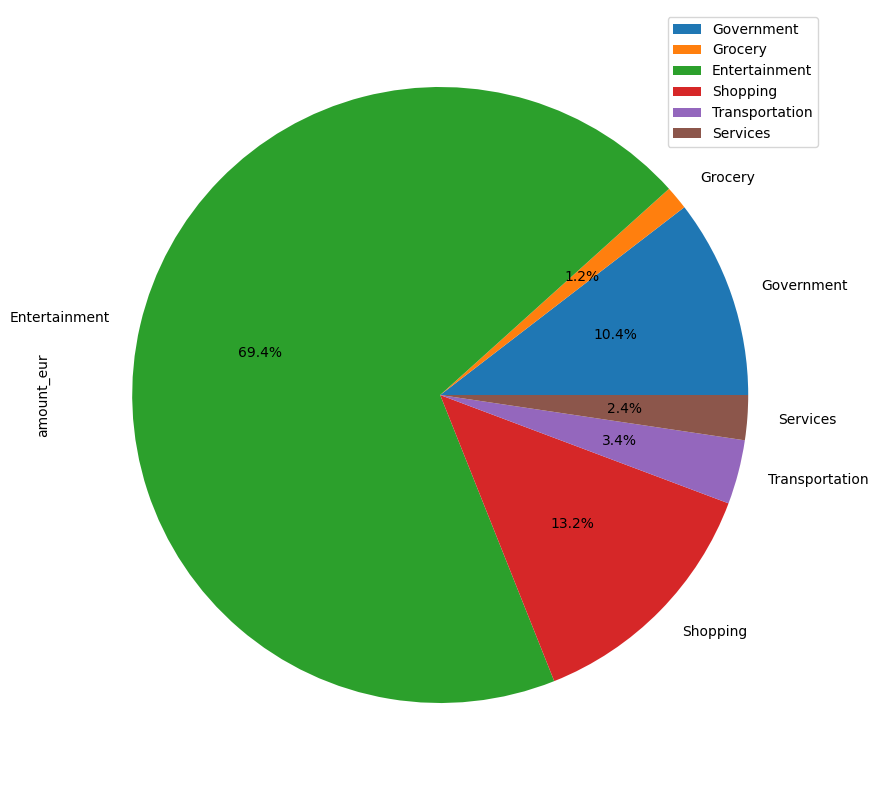

In [219]:
categorized_expenses \
    .groupby('category').agg({'amount_eur': 'sum'}).reset_index() \
    .plot.pie(y='amount_eur', labels=categorized_expenses['category'].unique(), autopct='%1.1f%%', figsize=(10, 10))